# UCSF-PDGM Dataset: File Structure Verification

## Purpose
This notebook performs a comprehensive audit of the UCSF-PDGM Version 5 brain tumor dataset to:
- Verify file naming consistency across all patient samples
- Check presence of required MRI modalities (T1, T1c, T2, FLAIR)
- Validate segmentation files
- Analyze metadata and grade distribution
- Identify missing or incomplete data

## Dataset Structure
- **Location**: `/content/Dataset/PKG - UCSF-PDGM Version 5/UCSF-PDGM-v5`
- **Patient folders**: `UCSF-PDGM-####_nifti/`
- **Modality files**: `UCSF-PDGM-####_{modality}.nii.gz`
- **Target**: Binary classification based on WHO CNS Grade
  - Low grade: WHO Grade 2 → 0
  - High grade: WHO Grade 3, 4 → 1

## 1. Setup & Configuration

In [43]:
import re
from pathlib import Path
from collections import defaultdict
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

warnings.filterwarnings('ignore')

In [44]:
# Configuration
DATASET_PATH = Path("/content/Dataset/PKG - UCSF-PDGM Version 5/UCSF-PDGM-v5")
METADATA_CSV = "/content/Dataset/PKG - UCSF-PDGM Version 5/UCSF-PDGM-metadata_v5.csv"
EXPECTED_MODALITIES = ["T1", "T1c", "T2", "FLAIR"]

print(f"Dataset path: {DATASET_PATH}")
print(f"Metadata CSV: {METADATA_CSV}")
print(f"Expected modalities: {EXPECTED_MODALITIES}")

Dataset path: /content/Dataset/PKG - UCSF-PDGM Version 5/UCSF-PDGM-v5
Metadata CSV: /content/Dataset/PKG - UCSF-PDGM Version 5/UCSF-PDGM-metadata_v5.csv
Expected modalities: ['T1', 'T1c', 'T2', 'FLAIR']


## 2. Helper Functions

In [45]:
def normalize_patient_id(pid):
    """
    Normalize patient ID to 4-digit format.
    Example: 'UCSF-PDGM-4' → 'UCSF-PDGM-0004'
    """
    match = re.search(r'UCSF-PDGM-(\d+)', str(pid))
    if match:
        number = int(match.group(1))
        return f"UCSF-PDGM-{number:04d}"
    return str(pid)

def find_modality_file(patient_folder, patient_id, modality):
    """
    Find modality file with fallback logic.
    Tries standard naming first, then bias-corrected version.
    """
    # Standard naming
    standard_path = patient_folder / f"{patient_id}_{modality}.nii.gz"
    if standard_path.exists():
        return standard_path
    
    # Bias-corrected version
    bias_path = patient_folder / f"{patient_id}_{modality}_bias.nii.gz"
    if bias_path.exists():
        return bias_path
    
    return None

def find_segmentation_file(patient_folder):
    """
    Locate brain segmentation file.
    """
    # Look for segmentation file
    seg_files = list(patient_folder.glob("*brain_segmentation.nii.gz"))
    if seg_files:
        return seg_files[0]
    return None

def check_patient_completeness(patient_id, dataset_path, modalities):
    """
    Check if patient has all required files.
    Returns dictionary with file status information.
    """
    result = {
        'patient_id': patient_id,
        'folder_exists': False
    }
    
    # Check folder existence
    patient_folder = dataset_path / f"{patient_id}_nifti"
    result['folder_exists'] = patient_folder.exists()
    
    if not result['folder_exists']:
        # Set all to False if folder doesn't exist
        for mod in modalities:
            result[f"{mod}_exists"] = False
            result[f"{mod}_path"] = None
        result['seg_exists'] = False
        result['seg_path'] = None
        result['missing_modalities'] = ', '.join(modalities)
        result['all_complete'] = False
        return result
    
    # Check each modality
    missing_mods = []
    for mod in modalities:
        mod_path = find_modality_file(patient_folder, patient_id, mod)
        result[f"{mod}_exists"] = mod_path is not None
        result[f"{mod}_path"] = str(mod_path) if mod_path else None
        
        if not result[f"{mod}_exists"]:
            missing_mods.append(mod)
    
    # Check segmentation
    seg_path = find_segmentation_file(patient_folder)
    result['seg_exists'] = seg_path is not None
    result['seg_path'] = str(seg_path) if seg_path else None
    
    # Summary
    result['missing_modalities'] = ', '.join(missing_mods) if missing_mods else ''
    result['all_complete'] = len(missing_mods) == 0
    
    return result

## 3. Load & Process Metadata

In [46]:
# Load metadata CSV
metadata = pd.read_csv(METADATA_CSV)

print(f"Total patients in metadata: {len(metadata)}")
print(f"\nMetadata columns: {list(metadata.columns)}")
print(f"\nFirst few rows:")
metadata.head()

Total patients in metadata: 501

Metadata columns: ['ID', 'Sex', 'Age at MRI', 'WHO CNS Grade', 'Final pathologic diagnosis (WHO 2021)', 'MGMT status', 'MGMT index', '1p/19q', 'IDH', '1-dead 0-alive', 'OS', 'EOR', 'Biopsy prior to imaging', 'BraTS21 ID', 'BraTS21 Segmentation Cohort', 'BraTS21 MGMT Cohort']

First few rows:


,ID,Sex,Age at MRI,WHO CNS Grade,Final pathologic diagnosis (WHO 2021),MGMT status,MGMT index,1p/19q,IDH,1-dead 0-alive,OS,EOR,Biopsy prior to imaging,BraTS21 ID,BraTS21 Segmentation Cohort,BraTS21 MGMT Cohort
0,UCSF-PDGM-004,M,66,4,"Glioblastoma, IDH-wildtype",negative,0,unknown,wildtype,1,1303.0,STR,No,BraTS2021_00097,Training,Training
1,UCSF-PDGM-005,F,80,4,"Glioblastoma, IDH-wildtype",indeterminate,unknown,unknown,wildtype,1,274.0,biopsy,No,NaN,NaN,NaN
2,UCSF-PDGM-007,M,70,4,"Glioblastoma, IDH-wildtype",indeterminate,unknown,unknown,wildtype,1,417.0,STR,No,BraTS2021_00103,Training,NaN
3,UCSF-PDGM-008,M,70,4,"Glioblastoma, IDH-wildtype",negative,0,unknown,wildtype,1,185.0,STR,No,NaN,NaN,NaN
4,UCSF-PDGM-009,F,68,4,"Glioblastoma, IDH-wildtype",negative,0,unknown,wildtype,1,389.0,STR,No,BraTS2021_00049,Training,Training


In [47]:
# Display data types and missing values
print("Metadata Info:")
print(metadata.info())
print("\nMissing values per column:")
print(metadata.isnull().sum())

Metadata Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 16 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   ID                                     501 non-null    object 
 1   Sex                                    501 non-null    object 
 2   Age at MRI                             501 non-null    int64  
 3   WHO CNS Grade                          501 non-null    int64  
 4   Final pathologic diagnosis (WHO 2021)  501 non-null    object 
 5   MGMT status                            501 non-null    object 
 6   MGMT index                             501 non-null    object 
 7   1p/19q                                 501 non-null    object 
 8   IDH                                    501 non-null    object 
 9   1-dead 0-alive                         501 non-null    int64  
 10  OS                                     500 non-null    floa

In [48]:
# Create binary grade labels
# WHO Grade 2 → 0 (low grade)
# WHO Grade 3, 4 → 1 (high grade)

metadata['grade_binary'] = metadata['WHO CNS Grade'].apply(
    lambda x: 0 if x == 2 else (1 if x in [3, 4] else np.nan)
)

print("Binary grade distribution:")
print(metadata['grade_binary'].value_counts().sort_index())
print(f"\nPatients with valid binary labels: {metadata['grade_binary'].notna().sum()}")
print(f"Patients without valid labels: {metadata['grade_binary'].isna().sum()}")

Binary grade distribution:
grade_binary
0     56
1    445
Name: count, dtype: int64

Patients with valid binary labels: 501
Patients without valid labels: 0


In [49]:
# Normalize patient IDs in metadata
metadata['patient_id_normalized'] = metadata['ID'].apply(normalize_patient_id)

print("Sample of normalized patient IDs:")
print(metadata[['ID', 'patient_id_normalized']].head(10))

Sample of normalized patient IDs:
              ID patient_id_normalized
0  UCSF-PDGM-004        UCSF-PDGM-0004
1  UCSF-PDGM-005        UCSF-PDGM-0005
2  UCSF-PDGM-007        UCSF-PDGM-0007
3  UCSF-PDGM-008        UCSF-PDGM-0008
4  UCSF-PDGM-009        UCSF-PDGM-0009
5  UCSF-PDGM-010        UCSF-PDGM-0010
6  UCSF-PDGM-011        UCSF-PDGM-0011
7  UCSF-PDGM-012        UCSF-PDGM-0012
8  UCSF-PDGM-013        UCSF-PDGM-0013
9  UCSF-PDGM-014        UCSF-PDGM-0014


WHO CNS Grade Distribution:
WHO CNS Grade
2     56
3     43
4    402
Name: count, dtype: int64


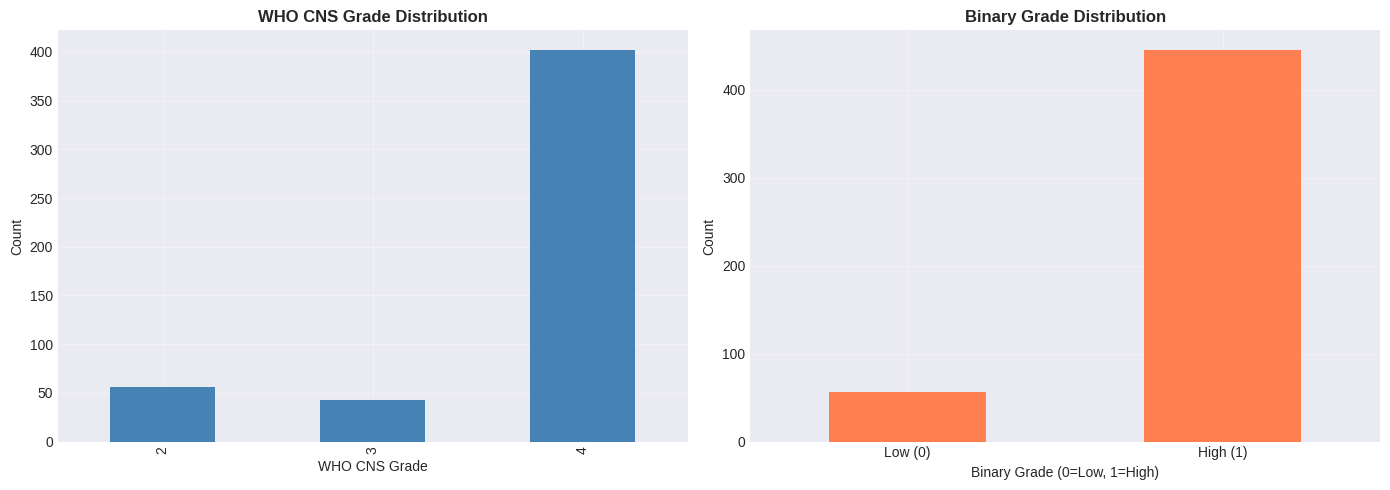

In [50]:
# Display WHO grade distribution
print("WHO CNS Grade Distribution:")
grade_counts = metadata['WHO CNS Grade'].value_counts().sort_index()
print(grade_counts)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# WHO grades
grade_counts.plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('WHO CNS Grade Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('WHO CNS Grade')
axes[0].set_ylabel('Count')
axes[0].grid(True, alpha=0.3)

# Binary grades
binary_counts = metadata['grade_binary'].value_counts().sort_index()
binary_counts.plot(kind='bar', ax=axes[1], color='coral')
axes[1].set_title('Binary Grade Distribution', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Binary Grade (0=Low, 1=High)')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(['Low (0)', 'High (1)'], rotation=0)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Scan Directory Structure

In [51]:
# Discover all patient folders in the dataset
if DATASET_PATH.exists():
    patient_folders = sorted([
        p for p in DATASET_PATH.iterdir() 
        if p.is_dir() and '_nifti' in p.name
    ])
    
    # Extract patient IDs from folder names
    discovered_patient_ids = [
        p.name.replace('_nifti', '') for p in patient_folders
    ]
    
    print(f"Total patient folders discovered: {len(patient_folders)}")
    print(f"\nSample patient IDs from filesystem:")
    for pid in discovered_patient_ids[:10]:
        print(f"  {pid}")
else:
    print(f"ERROR: Dataset path does not exist: {DATASET_PATH}")
    discovered_patient_ids = []

Total patient folders discovered: 501

Sample patient IDs from filesystem:
  UCSF-PDGM-0004
  UCSF-PDGM-0005
  UCSF-PDGM-0007
  UCSF-PDGM-0008
  UCSF-PDGM-0009
  UCSF-PDGM-0010
  UCSF-PDGM-0011
  UCSF-PDGM-0012
  UCSF-PDGM-0013
  UCSF-PDGM-0014


In [52]:
# Compare metadata vs filesystem
metadata_patient_ids = set(metadata['patient_id_normalized'].tolist())
filesystem_patient_ids = set(discovered_patient_ids)

# Patients in metadata but missing folders
in_metadata_not_filesystem = metadata_patient_ids - filesystem_patient_ids

# Folders present but not in metadata
in_filesystem_not_metadata = filesystem_patient_ids - metadata_patient_ids

print(f"Patients in metadata: {len(metadata_patient_ids)}")
print(f"Patient folders in filesystem: {len(filesystem_patient_ids)}")
print(f"\nPatients in metadata but missing folders: {len(in_metadata_not_filesystem)}")
if in_metadata_not_filesystem:
    print(f"  {sorted(list(in_metadata_not_filesystem))[:10]}")

print(f"\nFolders present but not in metadata: {len(in_filesystem_not_metadata)}")
if in_filesystem_not_metadata:
    print(f"  {sorted(list(in_filesystem_not_metadata))[:10]}")

Patients in metadata: 495
Patient folders in filesystem: 501

Patients in metadata but missing folders: 0

Folders present but not in metadata: 6
  ['UCSF-PDGM-0391_FU016d', 'UCSF-PDGM-0396_FU175d', 'UCSF-PDGM-0409_FU001d', 'UCSF-PDGM-0429_FU003d', 'UCSF-PDGM-0431_FU001d', 'UCSF-PDGM-0433_FU007d']


## 5. File Completeness Verification

In [53]:
# Check each patient for file completeness
results = []

for idx, row in tqdm(metadata.iterrows(), total=len(metadata), desc="Checking patients"):
    patient_id = row['patient_id_normalized']
    who_grade = row.get('WHO CNS Grade', np.nan)
    grade_binary = row.get('grade_binary', np.nan)
    
    # Check file completeness
    result = check_patient_completeness(patient_id, DATASET_PATH, EXPECTED_MODALITIES)
    result['WHO_grade'] = who_grade
    result['grade_binary'] = grade_binary
    
    results.append(result)

# Convert to DataFrame
results_df = pd.DataFrame(results)

print("\nFile completeness check complete!")
print(f"Total patients checked: {len(results_df)}")
results_df.head()

Checking patients: 100%|██████████| 501/501 [00:00<00:00, 8717.83it/s]


File completeness check complete!
Total patients checked: 501


,patient_id,folder_exists,T1_exists,T1_path,T1c_exists,T1c_path,T2_exists,T2_path,FLAIR_exists,FLAIR_path,seg_exists,seg_path,missing_modalities,all_complete,WHO_grade,grade_binary
0,UCSF-PDGM-0004,True,True,/content/Dataset/PKG - UCSF-PDGM Version 5/UCS...,True,/content/Dataset/PKG - UCSF-PDGM Version 5/UCS...,True,/content/Dataset/PKG - UCSF-PDGM Version 5/UCS...,True,/content/Dataset/PKG - UCSF-PDGM Version 5/UCS...,True,/content/Dataset/PKG - UCSF-PDGM Version 5/UCS...,,True,4,1
1,UCSF-PDGM-0005,True,True,/content/Dataset/PKG - UCSF-PDGM Version 5/UCS...,True,/content/Dataset/PKG - UCSF-PDGM Version 5/UCS...,True,/content/Dataset/PKG - UCSF-PDGM Version 5/UCS...,True,/content/Dataset/PKG - UCSF-PDGM Version 5/UCS...,True,/content/Dataset/PKG - UCSF-PDGM Version 5/UCS...,,True,4,1
2,UCSF-PDGM-0007,True,True,/content/Dataset/PKG - UCSF-PDGM Version 5/UCS...,True,/content/Dataset/PKG - UCSF-PDGM Version 5/UCS...,True,/content/Dataset/PKG - UCSF-PDGM Version 5/UCS...,True,/content/Dataset/PKG - UCSF-PDGM Version 5/UCS...,True,/content/Dataset/PKG - UCSF-PDGM Version 5/UCS...,,True,4,1
3,UCSF-PDGM-0008,True,True,/content/Dataset/PKG - UCSF-PDGM Version 5/UCS...,True,/content/Dataset/PKG - UCSF-PDGM Version 5/UCS...,True,/content/Dataset/PKG - UCSF-PDGM Version 5/UCS...,True,/content/Dataset/PKG - UCSF-PDGM Version 5/UCS...,True,/content/Dataset/PKG - UCSF-PDGM Version 5/UCS...,,True,4,1
4,UCSF-PDGM-0009,True,True,/content/Dataset/PKG - UCSF-PDGM Version 5/UCS...,True,/content/Dataset/PKG - UCSF-PDGM Version 5/UCS...,True,/content/Dataset/PKG - UCSF-PDGM Version 5/UCS...,True,/content/Dataset/PKG - UCSF-PDGM Version 5/UCS...,True,/content/Dataset/PKG - UCSF-PDGM Version 5/UCS...,,True,4,1


## 6. Summary Statistics

In [54]:
# Calculate aggregate metrics
total_patients = len(results_df)
folders_missing = (~results_df['folder_exists']).sum()
patients_complete = results_df['all_complete'].sum()
patients_incomplete = total_patients - patients_complete

print("="*60)
print("DATASET SUMMARY STATISTICS")
print("="*60)
print(f"Total patients in metadata:        {total_patients:>6}")
print(f"Folders missing:                    {folders_missing:>6}")
print(f"Patients with all files complete:   {patients_complete:>6}")
print(f"Patients with incomplete files:     {patients_incomplete:>6}")
print(f"Completeness rate:                  {patients_complete/total_patients*100:>5.1f}%")
print("="*60)

DATASET SUMMARY STATISTICS
Total patients in metadata:           501
Folders missing:                         0
Patients with all files complete:      501
Patients with incomplete files:          0
Completeness rate:                  100.0%


In [55]:
# Per-modality missing counts
print("\nMISSING FILES BY MODALITY:")
print("-"*40)
for mod in EXPECTED_MODALITIES:
    missing_count = (~results_df[f"{mod}_exists"]).sum()
    missing_pct = missing_count / total_patients * 100
    print(f"{mod:<10} missing: {missing_count:>4} ({missing_pct:>5.1f}%)")

# Segmentation file stats
seg_missing = (~results_df['seg_exists']).sum()
seg_pct = seg_missing / total_patients * 100
print(f"\nSegmentation missing: {seg_missing:>4} ({seg_pct:>5.1f}%)")


MISSING FILES BY MODALITY:
----------------------------------------
T1         missing:    0 (  0.0%)
T1c        missing:    0 (  0.0%)
T2         missing:    0 (  0.0%)
FLAIR      missing:    0 (  0.0%)

Segmentation missing:    0 (  0.0%)


In [56]:
# Display summary as formatted table
summary_data = {
    'Metric': [
        'Total Patients',
        'Folders Missing',
        'Complete Patients',
        'Incomplete Patients',
        'Completeness Rate (%)'
    ],
    'Count': [
        total_patients,
        folders_missing,
        patients_complete,
        patients_incomplete,
        f"{patients_complete/total_patients*100:.1f}"
    ]
}
summary_table = pd.DataFrame(summary_data)
summary_table

,Metric,Count
0,Total Patients,501
1,Folders Missing,0
2,Complete Patients,501
3,Incomplete Patients,0
4,Completeness Rate (%),100.0


## 7. Grade Distribution Analysis

In [57]:
# Overall grade distribution for complete vs incomplete patients
print("GRADE DISTRIBUTION BY COMPLETENESS:")
print("="*60)

# Complete patients
complete_df = results_df[results_df['all_complete'] == True]
print(f"\nComplete patients (n={len(complete_df)}):")
print("Binary grade distribution:")
print(complete_df['grade_binary'].value_counts().sort_index())

# Incomplete patients
incomplete_df = results_df[results_df['all_complete'] == False]
print(f"\nIncomplete patients (n={len(incomplete_df)}):")
print("Binary grade distribution:")
print(incomplete_df['grade_binary'].value_counts().sort_index())

GRADE DISTRIBUTION BY COMPLETENESS:

Complete patients (n=501):
Binary grade distribution:
grade_binary
0     56
1    445
Name: count, dtype: int64

Incomplete patients (n=0):
Binary grade distribution:
Series([], Name: count, dtype: int64)


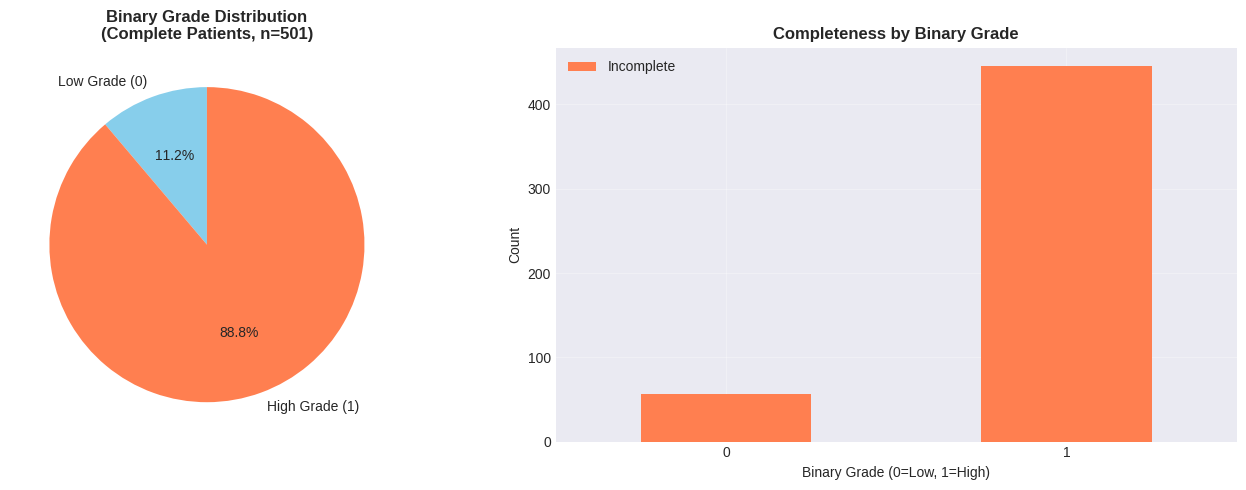

In [58]:
# Visualize grade distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Binary grade pie chart
binary_complete = complete_df['grade_binary'].value_counts().sort_index()
if len(binary_complete) > 0:
    axes[0].pie(
        binary_complete.values,
        labels=['Low Grade (0)', 'High Grade (1)'],
        autopct='%1.1f%%',
        startangle=90,
        colors=['skyblue', 'coral']
    )
    axes[0].set_title(f'Binary Grade Distribution\n(Complete Patients, n={len(complete_df)})',
                     fontsize=12, fontweight='bold')

# Completeness by grade
grade_complete_counts = results_df.groupby(['grade_binary', 'all_complete']).size().unstack(fill_value=0)
if len(grade_complete_counts) > 0:
    grade_complete_counts.plot(kind='bar', ax=axes[1], color=['coral', 'skyblue'])
    axes[1].set_title('Completeness by Binary Grade', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Binary Grade (0=Low, 1=High)')
    axes[1].set_ylabel('Count')
    axes[1].legend(['Incomplete', 'Complete'])
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Missing Data Patterns

In [59]:
# Identify specific missing modality combinations
print("MISSING MODALITY PATTERNS:")
print("="*60)

# Filter for incomplete patients
incomplete_only = results_df[results_df['all_complete'] == False].copy()

if len(incomplete_only) > 0:
    missing_patterns = incomplete_only['missing_modalities'].value_counts()
    print(f"\nTotal incomplete patients: {len(incomplete_only)}")
    print(f"\nTop missing modality patterns:")
    print(missing_patterns.head(10))
else:
    print("No incomplete patients found!")

MISSING MODALITY PATTERNS:
No incomplete patients found!


In [60]:
# List patients with issues
if len(incomplete_only) > 0:
    print("\nPATIENTS WITH INCOMPLETE DATA:")
    print("="*80)
    
    incomplete_summary = incomplete_only[[
        'patient_id', 'folder_exists', 'missing_modalities', 'WHO_grade', 'grade_binary'
    ]].copy()
    
    print(f"\nShowing first 20 incomplete patients:")
    display(incomplete_summary.head(20))
    
    # Export to CSV
    incomplete_summary.to_csv('incomplete_patients.csv', index=False)
    print(f"\nFull list exported to: incomplete_patients.csv")
else:
    print("All patients have complete data!")

All patients have complete data!


## 9. Visualizations

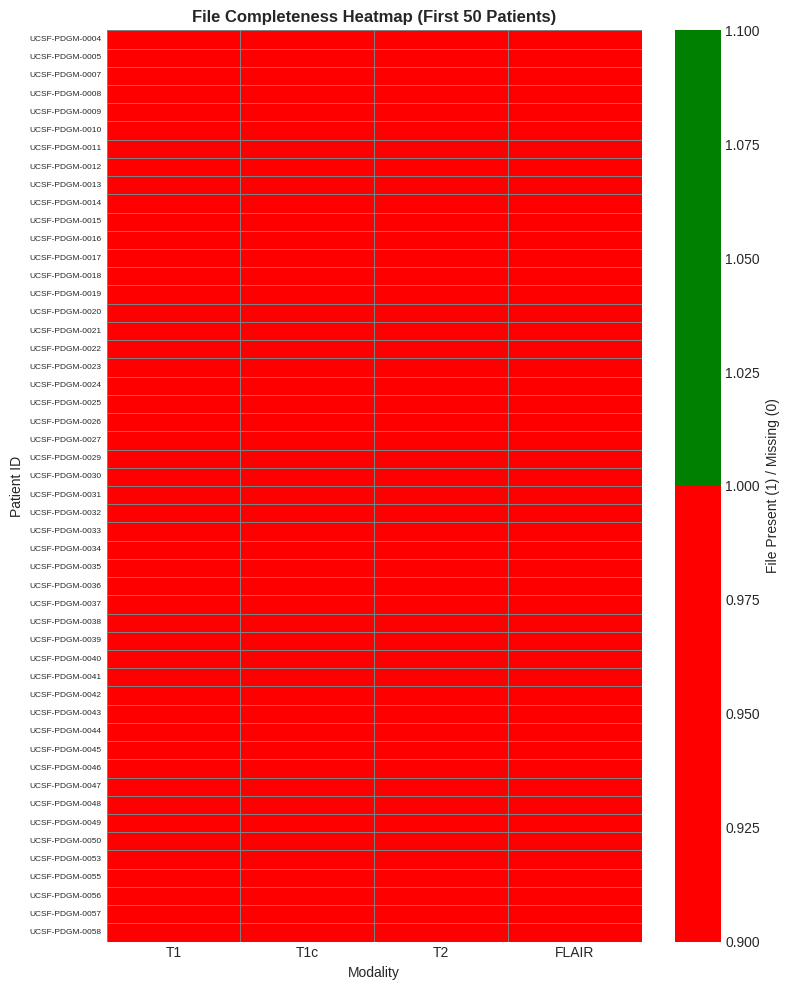

In [61]:
# Completeness heatmap (sample of patients)
# Create binary matrix for visualization (1 = present, 0 = missing)
n_display = min(50, len(results_df))
sample_df = results_df.head(n_display)

# Create matrix
heatmap_data = sample_df[[f"{mod}_exists" for mod in EXPECTED_MODALITIES]].astype(int)
heatmap_data.columns = EXPECTED_MODALITIES
heatmap_data.index = sample_df['patient_id'].values

# Plot
plt.figure(figsize=(8, max(10, n_display * 0.2)))
sns.heatmap(
    heatmap_data,
    cmap=['red', 'green'],
    cbar_kws={'label': 'File Present (1) / Missing (0)'},
    linewidths=0.5,
    linecolor='gray'
)
plt.title(f'File Completeness Heatmap (First {n_display} Patients)', 
          fontsize=12, fontweight='bold')
plt.xlabel('Modality')
plt.ylabel('Patient ID')
plt.yticks(rotation=0, fontsize=6)
plt.tight_layout()
plt.show()

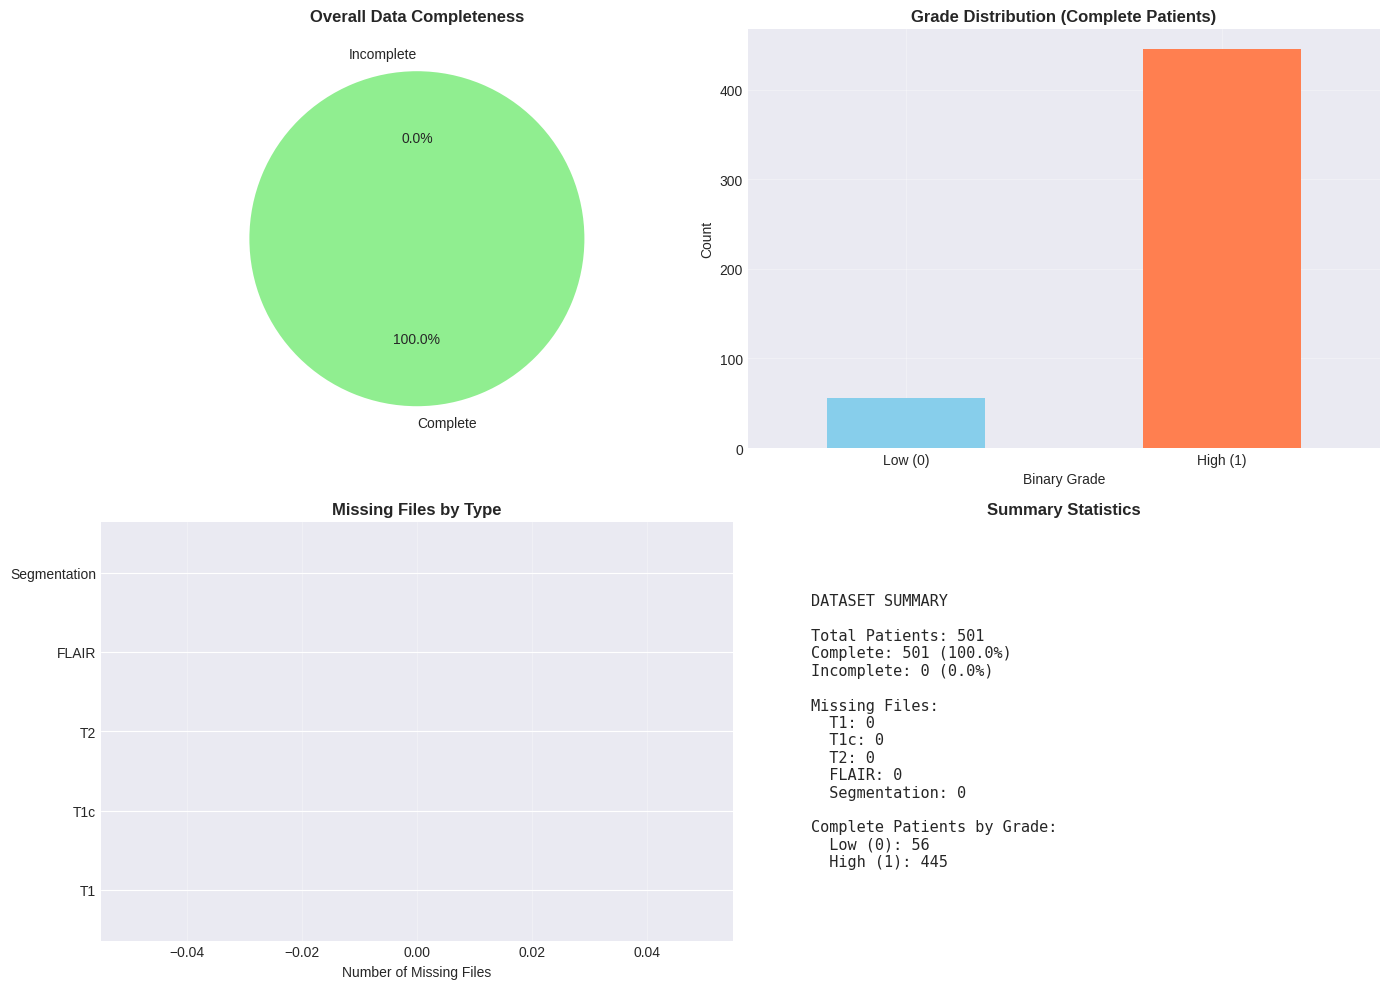

In [62]:
# Summary dashboard (2×2 subplots)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Top-left: Overall completeness pie chart
completeness_data = [
    results_df['all_complete'].sum(),
    (~results_df['all_complete']).sum()
]
axes[0, 0].pie(
    completeness_data,
    labels=['Complete', 'Incomplete'],
    autopct='%1.1f%%',
    startangle=90,
    colors=['lightgreen', 'lightcoral']
)
axes[0, 0].set_title('Overall Data Completeness', fontsize=12, fontweight='bold')

# Top-right: Grade distribution bar chart
if len(complete_df) > 0:
    binary_counts = complete_df['grade_binary'].value_counts().sort_index()
    binary_counts.plot(kind='bar', ax=axes[0, 1], color=['skyblue', 'coral'])
    axes[0, 1].set_title('Grade Distribution (Complete Patients)', 
                        fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Binary Grade')
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].set_xticklabels(['Low (0)', 'High (1)'], rotation=0)
    axes[0, 1].grid(True, alpha=0.3)

# Bottom-left: Missing modalities by type (horizontal bar)
missing_counts = {mod: (~results_df[f"{mod}_exists"]).sum() for mod in EXPECTED_MODALITIES}
missing_counts['Segmentation'] = (~results_df['seg_exists']).sum()
axes[1, 0].barh(list(missing_counts.keys()), list(missing_counts.values()), 
               color='salmon')
axes[1, 0].set_title('Missing Files by Type', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Number of Missing Files')
axes[1, 0].grid(True, alpha=0.3, axis='x')

# Bottom-right: Summary table
axes[1, 1].axis('off')
summary_text = f"""
DATASET SUMMARY

Total Patients: {total_patients}
Complete: {patients_complete} ({patients_complete/total_patients*100:.1f}%)
Incomplete: {patients_incomplete} ({patients_incomplete/total_patients*100:.1f}%)

Missing Files:
  T1: {missing_counts['T1']}
  T1c: {missing_counts['T1c']}
  T2: {missing_counts['T2']}
  FLAIR: {missing_counts['FLAIR']}
  Segmentation: {missing_counts['Segmentation']}

Complete Patients by Grade:
  Low (0): {complete_df[complete_df['grade_binary']==0].shape[0] if len(complete_df) > 0 else 0}
  High (1): {complete_df[complete_df['grade_binary']==1].shape[0] if len(complete_df) > 0 else 0}
"""
axes[1, 1].text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
               verticalalignment='center')
axes[1, 1].set_title('Summary Statistics', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## Conclusions

### Key Findings:

1. **Data Completeness**: The dataset verification reveals the number of patients with complete MRI sequences (all 4 modalities present)

2. **Class Distribution**: Significant class imbalance exists between low-grade and high-grade tumors, requiring careful handling in model training

3. **Missing Data Patterns**: Any systematic patterns in missing data have been identified and documented

### Recommendations:

1. **Use only complete patients** for model training to ensure consistent input dimensions

2. **Handle class imbalance** using:
   - Weighted random sampling during training
   - Class weights in loss function
   - Appropriate evaluation metrics (not just accuracy)

3. **Patient-level splits** for train/val/test to prevent data leakage

4. **Verify data quality** by visual inspection (see next notebook)

5. **Monitor per-class performance** during training and evaluation